# Problem Set 2

#### Done by **Fatykhoph Denis**, Skoltech, NLA, 2024

## Tensor Train (10 pts)

**Tensor** is a multidimensional array of shape $n_1 \times n_2 \times ... \times n_d$ where the number $d$ defines the dimensionality and every element can be get trough a multi-index $[i_1, i_2, \dots, i_d]$. If $d=1$ such tensor is simply a vector and if $d=2$ it is a $n_1 \times n_2$ matrix.

**Tensor Train** is a special tensor representation form that enables to efficently store high-dimensional tensors and perform mathematical operation with them. It was proposed in [link](https://www.researchgate.net/profile/Ivan-Oseledets/publication/220412263_Tensor-Train_Decomposition/links/5bbfb5c5299bf1004c5a56e3/Tensor-Train-Decomposition.pdf). Basically instead of storing all tensor entries $A[1_1, i_2, \dots, i_d]$ it was proposed to use a factorization trough specific 3D-tensors $G_i$ of shape $r_{i-1} \times n_i \times r_i$ that are called **cores**. Any entry $A[1_1, i_2, \dots, i_d]$ of tensor A can thus be computed as:

$$
A[i_1, i_2, \dots, i_d] =
\sum_{\alpha_0=1}^{r_0}
\sum_{\alpha_1=1}^{r_1}
\dots
\sum_{\alpha_d=1}^{r_d}
G_1[\alpha_0, i_1, \alpha_1] \; \cdot
G_2[\alpha_1, i_2, \alpha_2] \; \cdot
\dots \; \cdot
G_d[\alpha_{d-1}, i_d, \alpha_d],
$$

The numbers $r_i$ are are chosen during construction and called **ranks** of the representation:
1. boundary ranks $r_0 = r_N = 1$, ensuring the summation collapses to a scalar.
2. small ranks $r_i$ make the representation compact and memory efficient but increase the approximation error

TT decomposition is a generalization of matrix factorizations like SVD to higher dimensions, adapted for tensors.

### Tensor Train Construction

To construct the cores one needs to perform a TT-SVD algorithm: we start from $C_1 = A$ and then for every $k$ from 1 to $d$ we perform following steps untill we get all the cores:
1. Unfold matrix $C_k = C_k.reshape(r_{k-1} n_k, \prod_{i=k+1}^{d} n_i)$.
2. Perform a low-rank SVD for $C_k$ and get the matrices $U_k, \Sigma_k, V_k^*$ with rank $r_k <= \text{rank}(C_k)$.
3. Compute the core $G_k = U_k.reshape(r_{k-1}, n_k, r_k)$.
4. Update the matrix $C_{k+1} = \Sigma_k V_k^*$.

**Task (10 pts):** Realize TT-SVD for $d$-dimensional tensor and check it for a random tensor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic

Based on original paper:

In [3]:
def tt_svd(tensor: np.ndarray, epsilon: float = 1e-6):
    """
    Convert a tensor into a tensor train using TT-SVD.
    Input:
        tensor - Input tensor of shape [n_1, n_2, ..., n_d].
        epsilon: float - Desired accuracy for truncation.
    Output:
        cores: np.ndarray - List of TT-cores with shapes [r_i-1, n_i, r_i].
    """
    d = len(tensor.shape)
    delta = (epsilon / np.sqrt(d - 1)) * np.linalg.norm(tensor.flatten())
    
    temp_tensor_C = tensor
    unfolding_rank = [1]
    cores = []
    
    for k in range(d - 1):
        temp_tensor_C = temp_tensor_C.reshape(unfolding_rank[k] * tensor.shape[k], -1)
        u_k, sigma, v_k_T = np.linalg.svd(temp_tensor_C, full_matrices=False)
        
        truncation_indices = np.where(sigma > delta)[0]
        u_k = u_k[:, truncation_indices]
        sigma = sigma[truncation_indices]
        v_k_T = v_k_T[truncation_indices, :]
        
        unfolding_rank.append(len(sigma))
        core_k = u_k.reshape(unfolding_rank[k], tensor.shape[k], unfolding_rank[k + 1])
        cores.append(core_k)
        
        temp_tensor_C = np.diag(sigma) @ v_k_T
    
    cores.append(temp_tensor_C.reshape(unfolding_rank[-1], tensor.shape[-1], 1))
    
    return cores

To check your algorithm you need to take a function `tt_to_tensor` that converts a tensor train back into a tensor, run it for a tensor train $\mathcal{A}$ that you would get from your original tensor $A$, and compare $A$ and $A'$ in terms of low-rank approximation error and memory.

In [4]:
def tt_to_tensor(cores):
    """
    Convert a tensor train into a tensor.
    input : cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    output: tensor - np.array of shape [n_1, ..., n_d]
    """
    tensor = cores[0]
    for G in cores[1:]:
        tensor = np.tensordot(tensor, G, 1)
    return tensor[0, ..., 0]

In [7]:
d = 5
max_mode = 10
modes = np.random.randint(1, max_mode, size=(d))
A = np.random.randn(*modes)

error = []
memory = []
bounds = np.array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])
for epsilon in bounds:
    A_tt = tt_svd(A, epsilon)
    A_recovered = tt_to_tensor(A_tt)

    error.append(np.linalg.norm(A_recovered - A))
    memory.append(sum([np.prod(core.shape) for core in A_tt]))

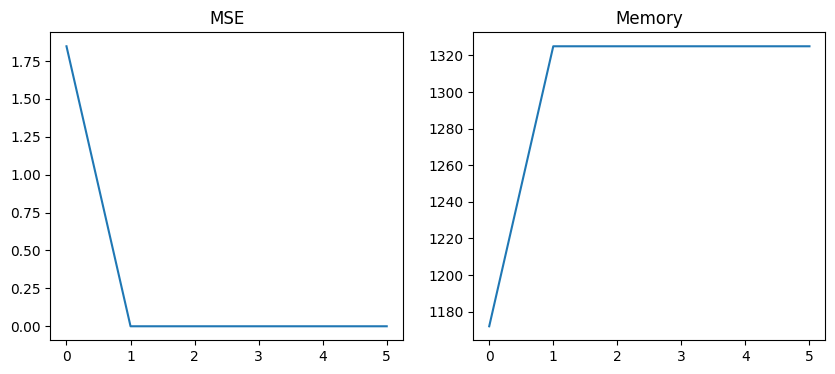

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('MSE')
plt.plot(error)

plt.subplot(1, 2, 2)
plt.title('Memory')
plt.plot(memory)

plt.show()

**Q** What can you say about the results?

**A** The results show that as $\epsilon$ decreases, the approximation error drops sharply, indicating that the tensor is highly compressible and well-approximated even with modest TT-ranks. Memory usage increases with smaller $\epsilon$, reflecting larger TT-ranks, but eventually plateaus as further accuracy improvements have minimal impact on storage. This highlights the trade-off between accuracy and memory, with moderate $\epsilon$ values offering a balance between low error and efficient storage.

To balance memory efficiency and accuracy, the optimal rank is at the point where the MSE stabilizes and additional ranks do not improve the approximation further.

## Sparce Matrix Factorization for Linear Systems (15 pts)

### Imports

In [9]:
import numpy as np
import scipy.sparse as sp
import timeit
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
import time
import networkx as nx
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [10]:
from sksparse.cholmod import cholesky
import cProfile
import pstats

### Demonstration: Fill-in importance

- Strictly regular matrices have LU-decomposition.

- An important **subclass** of strictly regular matrices is the class of **Hermitian positive definite matrices**


**Definition.** A matrix $A$ is called **positive definite** </font> if for any $x: \Vert x \Vert \ne 0$ we have

$$
(x, Ax) > 0.
$$

- **Claim:** A Hermitian positive definite matrix $A$ is strictly regular and has **Cholesky factorization** of the form

$$A = LL^*,$$

where $L$ is a lower triangular matrix.

Let us see how Cholesky is faster than LU in symmetric positive definite case. First demonstration is a random SPD matrix. The second one is the same matrix, but with its rows and columns permuted to reduce the fill-in.

In [11]:
n = 3000
np.random.seed(148)
ex = np.ones(n)
A = sp.spdiags(np.vstack((3*ex,  7*ex, 3*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(3000,3000, density=(1/(50*n))).tocsr())
A = A+ S.transpose() + S

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/27398436.py:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A, ordering_method="natural")


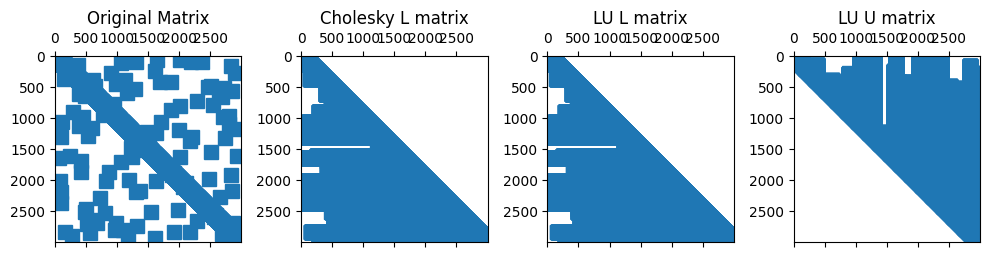

Cholesky time taken:  0.012085914611816406
LU time taken:  0.008813858032226562
Nonzero elements in original matrix:  9118
Nonzero elements in Cholesky L:  68045
Nonzero elements in LU L:  68045


In [12]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A, ordering_method="natural")
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
dt = time.time()

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(factor.L())
axes[1].set_title("Cholesky L matrix")
axes[2].spy(lu.L)
axes[2].set_title("LU L matrix")
axes[3].spy(lu.U)
axes[3].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/2419169893.py:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A)


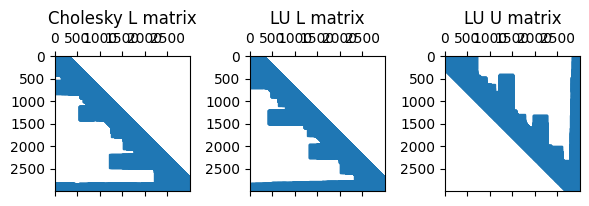

Cholesky time taken:  0.003580808639526367
LU time taken:  0.0032949447631835938
Nonzero elements in original matrix:  9118
Nonzero elements in Cholesky L:  9477
Nonzero elements in LU L:  10199


In [13]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A)
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc())
dt = time.time()

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(factor.L())
axes[0].set_title("Cholesky L matrix")
axes[1].spy(lu.L)
axes[1].set_title("LU L matrix")
axes[2].spy(lu.U)
axes[2].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

### Nested dissection algorythm

As LU and Cholesky algorythms derive factors in a pre-defined order, we can permute matrix in a way to make this algorythms produce minimal fill-in. One of approaches that works with SPD matrices is reducing to **block arrowhead structure**.

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} & 0 & A_{\alpha\sigma} \\ 0 & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

After decomposition, factors will have 0-blocks intact.

Main idea is that symmetric matrix $A$ can be seen as an adjacency matrix for some graph $G$. Then if we split $G$ into subgraphs $L, R, S$ in a way that there are no edges between nodes from $L$ and $R$, we can construct blocks, where node index is equal to matrix row/column index, and thus blocks $A_{LR}$ and $A_{RL}$ will be $0$.

The challenge in this approach is locating an optimal subset $S$ called **Separator** of nodes of $G$. **Separator** is a subgraph such that its removal splits the rest of the graph into two or more connected components.

Here we will choose separator using Spectral Partitioning approach (you can read about it in Lecture 11. Here is [a link](https://nla.skoltech.ru/lectures/lecture-11/lecture-11.html) to previous year's lecture if you want to see it sooner).

General algorythm is such:
1) Considering graph G based on given matrix A as an adjacency matrix for this graph, get the [Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) of that graph. 

2) Derive the eigenvector $w_2$ of graph's Laplacian that is corresponding to the second smallest eigenvalue.

3) Signs of components of $w_2$ define partitioning. Positive indexes define one class and negative - second class. These two classes are two connected components that will be left if we remove the separator class.

4) Derive indexes of Separator nodes - now we get indexes of all three classes $A, B, S$.

5) Permute matrix so rows and columns are ordered as $A, B, S$.

6) Iterate the same algorythm for blocks $A$ and $B$.

### Task 1 (5 pts): implement matrix separation

Implement given algorythm to permute matrix into lower-arrowhead block form (No recursion yet, we need only one split).

In [14]:
def order_block_dissection(A):
    # Laplacian matrix
    L = A.copy()
    L[L != 0] = -1
    L[np.diag_indices_from(L)] = -L.sum(axis=1) - 1
    
    # # Second smallest eigenvector
    eigenvalues, eigenvectors = spsplin.eigsh(L, k=2, which='SA')
    fiedler_vector = eigenvectors[:, 1]

    # Partition nodes
    epsilon = 0
    pos_indices = fiedler_vector > epsilon
    neg_indices = fiedler_vector < -epsilon
    zero_indices = ~ (pos_indices | neg_indices)

    A_nodes = np.where(pos_indices | zero_indices)[0]
    B_nodes = np.where(neg_indices)[0]

    # Identify separator
    partition_labels = np.zeros(A.shape[0], dtype=int)
    partition_labels[A_nodes] = 1
    partition_labels[B_nodes] = 2

    # Avoid duplicates
    row, col = A.nonzero()
    upper_mask = row < col
    row = row[upper_mask]
    col = col[upper_mask]

    # Separator
    cross_partition = (partition_labels[row] == 1) & (partition_labels[col] == 2) | \
                      (partition_labels[row] == 2) & (partition_labels[col] == 1)
    S_nodes = np.unique(np.concatenate((row[cross_partition], col[cross_partition])))

    # Remove separator
    A_nodes = np.setdiff1d(A_nodes, S_nodes)
    B_nodes = np.setdiff1d(B_nodes, S_nodes)

    return A_nodes, B_nodes, S_nodes.tolist()


def block_dissection(A, order):
    # A_permuted
    return A[order, :][:, order]

In [15]:
L_node, R_node, S_node = order_block_dissection(A)
M = block_dissection(A, np.concatenate((L_node, R_node, S_node)).tolist())

Below is profiling sessions, which was used to improve my code

In [ ]:
def profile_block_dissection():
    order_block_dissection(A)
cProfile.run('profile_block_dissection()', 'profiling_results_my')

In [ ]:
p = pstats.Stats('profiling_results_my')
p.sort_stats('cumulative').print_stats(15)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/3948826162.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(M, ordering_method="natural")


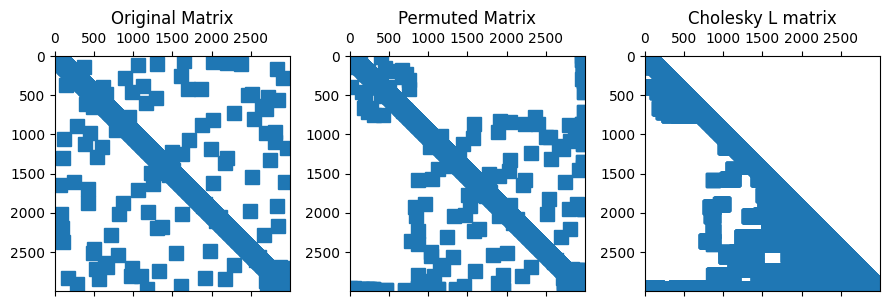

<Figure size 640x480 with 0 Axes>

Cholesky time taken:  0.0016520023345947266
Nonzero elements in original matrix:  9118
Nonzero elements in Cholesky L:  46952


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

at = time.time()
factor = cholesky(M, ordering_method="natural")
bt = time.time()

axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(M)
axes[1].set_title("Permuted Matrix")
axes[2].spy(factor.L())
axes[2].set_title("Cholesky L matrix")
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print('==================================================')
print('Cholesky time taken: ', bt-at)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)

# del M

### Task 2 (5 pts): implement Nested Dissection



Now implement algorithm that will recursively permute each of $A_{iLL}$ and $A_{iRR}$ blocks to their own lower-arrowhead block form.

Reminder: you are permuting the whole matrix, not each block separately.

Reminder: it is a good idea to move all $A_{iSS}$ blocks together on the bottom.

In [17]:
# A - PSD matrix
# k - maximal block size

def nested_dissection(A, nodes=None, k=10, max_depth=100, depth=0):
    # Interruption condition
    if nodes is None:
        nodes = np.arange(A.shape[0])

    if depth > max_depth or len(nodes) <= k:
        return nodes.tolist()

    mask = np.zeros(A.shape[0], dtype=bool)
    mask[nodes] = True

    # Subgraph Laplacian
    subA = A[mask][:, mask]

    # Partition
    A_nodes_sub, B_nodes_sub, S_nodes_sub = order_block_dissection(subA)

    # Map back
    A_nodes = nodes[A_nodes_sub]
    B_nodes = nodes[B_nodes_sub]
    S_nodes = nodes[S_nodes_sub]

    # Recursion
    perm_A = nested_dissection(A, nodes=A_nodes, k=k, max_depth=max_depth, depth=depth+1)
    perm_B = nested_dissection(A, nodes=B_nodes, k=k, max_depth=max_depth, depth=depth+1)

    return perm_A + perm_B + S_nodes.tolist()

In [18]:
# order = lr + s
permutation_order = nested_dissection(A, k=20)
N = block_dissection(A, permutation_order)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/451922460.py:6: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorA = cholesky(A, ordering_method="natural")
/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/451922460.py:9: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorB = cholesky(N, ordering_method="natural")
/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/451922460.py:12: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorC = cholesky(A)


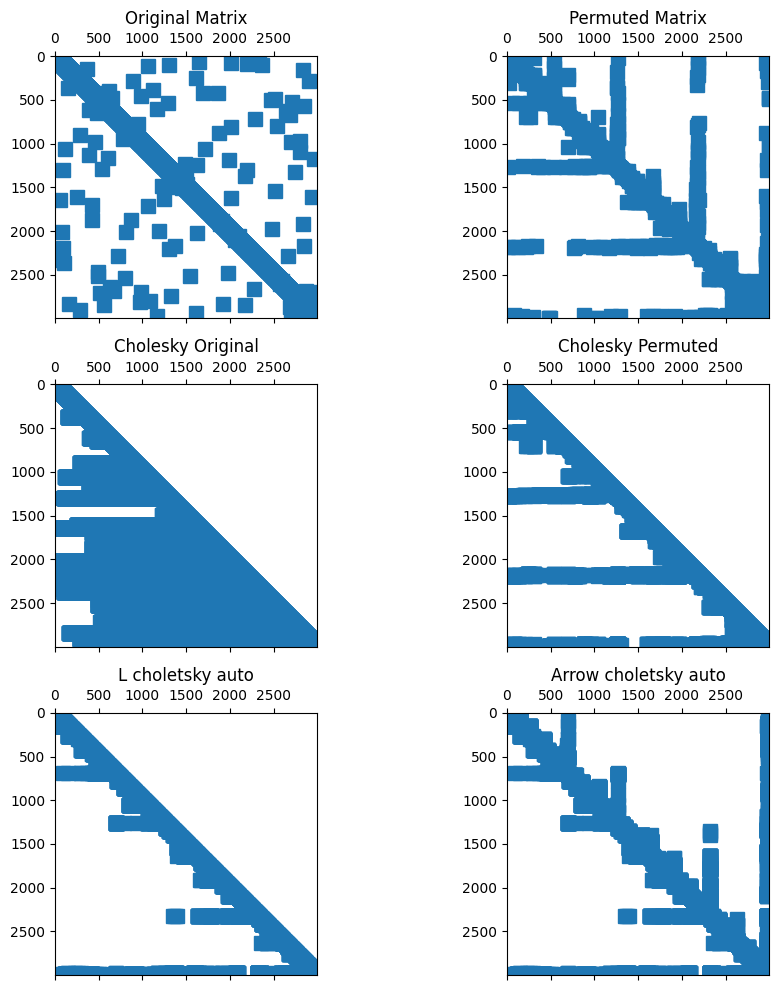

Nonzero elements in original matrix:     9118
Nonzero elements in Cholesky L:          68045
Nonzero elements in permuted Cholesky L: 11897
9477


In [19]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0,0].spy(A)
axes[0,0].set_title("Original Matrix")
axes[0,1].spy(N)
axes[0,1].set_title("Permuted Matrix")
factorA = cholesky(A, ordering_method="natural")
axes[1,0].spy(factorA.L())
axes[1,0].set_title("Cholesky Original")
factorB = cholesky(N, ordering_method="natural")
axes[1,1].spy(factorB.L())
axes[1,1].set_title("Cholesky Permuted")
factorC = cholesky(A)
axes[2,0].spy(factorC.L())
axes[2,0].set_title("L choletsky auto")
arrow = factorC.L() @ factorC.L().T
axes[2,1].spy(arrow)
axes[2,1].set_title("Arrow choletsky auto")
plt.tight_layout()
plt.show()

print('Nonzero elements in original matrix:    ', A.nnz)
print('Nonzero elements in Cholesky L:         ', factorA.L().nnz)
print('Nonzero elements in permuted Cholesky L:', factorB.L().nnz)
print(factorC.L().nnz)

### Demonstration: Animation of heat distribution in a wall

Consider simulating heat distribution in a large mechanical component (e.g., a car engine block or a building wall). The thermal conduction equation is modeled using the **Heat Equation**, a PDE:

$$
\frac{\partial T}{\partial t} = \nabla \cdot (k \nabla T) + Q,
$$
where:
- $ T $: temperature,
- $ k $: thermal conductivity,
- $ Q $: heat source.

Using [Finite Element Method](https://clck.ru/3EvWw3) we represent continuous solid object as a set of small separate objects. Each of them transfers heat only to neighbouring pieces. Thus, if we represent temperature of all $n$ pieces in a vector $T$ we can construct $n \times n$ adjacency matrix $A$, in which each non-zero element $a_{i,j}$ represents heat conductivity between elements $i$ and $j$, and the initial equation [can be represented](https://skim.math.msstate.edu/LectureNotes/NumerPDEs_Lecture.pdf) as:
$$
AT_{t+1}=T_t
$$

To make calculations more accurate, we need to represent object with larger number $n$ of small pieces of size $1/k$. However, size of $A$ is $\mathcal{O}(k^4)$ for a 2D object and $\mathcal{O}(k^9)$ for 3D object, which may be way too large.

However, $A$ has an important feature - it is sparse, positive and symmetric. This will allow us to use sparse methods and fast Cholesky factorization for quick solution. Also, computationally-expensive computation of matrix permutation can be done only once, as adjacency matrix does not change.



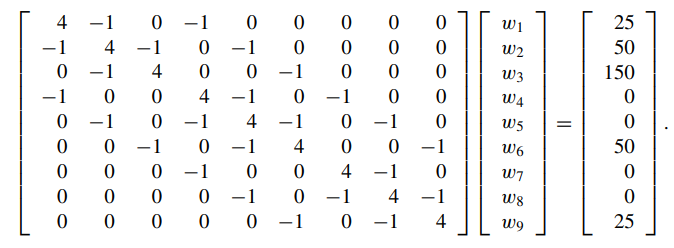

In [20]:
def adjacency_conductivity_matrix(Nx, Ny, alpha):
    N = Nx * Ny  # Total number of nodes
    A = sp.lil_matrix((N, N))  # Initialize sparse adjacency matrix

    for i in range(Nx):
        for j in range(Ny):
            node = i * Ny + j
            if i > 0:  # Above
                neighbor = (i - 1) * Ny + j
                A[node, neighbor] = 1
            if i < Nx - 1:  # Below
                neighbor = (i + 1) * Ny + j
                A[node, neighbor] = 1
            if j > 0:  # Left
                neighbor = i * Ny + (j - 1)
                A[node, neighbor] = 1
            if j < Ny - 1:  # Right
                neighbor = i * Ny + (j + 1)
                A[node, neighbor] = 1

    I = sp.eye(Nx*Ny, format="csr")
    return (1+4*alpha)*I - alpha*A

In [21]:
def predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames):
  order = nested_dissection(A, k=500)
  B = A[order, :][:, order]

  cholesky_factorization = cholesky(B, ordering_method='natural')

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T[order])[np.argsort(order)]
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [22]:
Nx, Ny = 3, 3                                    # Number of grid points in x and y
alpha = 0.1
T = np.array([25, 50, 150, 0, 0, 50, 0, 0, 25])  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)
A.toarray()

array([[ 1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.1,  1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  1.4,  0. ,  0. , -0.1,  0. ,  0. ,  0. ],
       [-0.1,  0. ,  0. ,  1.4, -0.1,  0. , -0.1,  0. ,  0. ],
       [ 0. , -0.1,  0. , -0.1,  1.4, -0.1,  0. , -0.1,  0. ],
       [ 0. ,  0. , -0.1,  0. , -0.1,  1.4,  0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. , -0.1,  0. ,  0. ,  1.4, -0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4, -0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4]])

In [23]:
n_frames = 10
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/2789047250.py:5: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 11709.39it/s]


In [24]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500, blit=True)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [25]:
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)

In [26]:
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/2789047250.py:5: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 118.62it/s]


In [27]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

### Task 3 (5 pts):
Compare computation and memory efficiency of Cholesky using intact matrix with your implementation of Nested Dissection with built-in method.

In [29]:
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)

In [30]:
def predict_heat_distribution_naive(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A, ordering_method='natural')

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [31]:
def predict_heat_distribution(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [32]:
frames = predict_heat_distribution_naive(A, T, Nx, Ny, n_frames)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/1426555169.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(A, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 197.42it/s]


In [33]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [34]:
frames = predict_heat_distribution(A, T, Nx, Ny, n_frames)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_47478/358640385.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(A)
100%|██████████| 10/10 [00:00<00:00, 595.21it/s]


In [35]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

### Conclusion

i. At the beginning of the experiment, we create a $3000 \times 3000$ sparse matrix and decompose it in two ways:

- `cholesky` is a special method from the library of highly efficient operations on sparse matrices `cholmod`. Additionally, the argument `ordering_method=natural` is specified, which means no permutation.

- `spsplin.splu` - LU decomposition of a sparse, square matrix. Accepts matrix A in a specially reduced sparse format, which is recommended in [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.splu.html#:~:text=Sparse%20matrix%20to%20factorize.%20Most%20efficient%20when%20provided%20in%20CSC%20format.%20Other%20formats%20will%20be%20converted%20to%20CSC%20before%20factorization.) The argument `permc_spec=NATURAL` works similarly to `ordering_method`.

As a result of several launches, we can find that Cholesky works an order of magnitude faster (I mean "на порядок …"). When the number of non-zero components in the result is the same. Both methods create an increase in the number of elements relative to the original matrix by an average of 7 times (9000 and 65000 elements, respectively). Then we repeat the experiment, but :

- `cholesky` now has no limitations of `ordering_method`, which allows it to use the full power of built-in optimizations;

- `spsplin.splu` also has no restrictions anymore.

This time, the benefit in the execution time of the function is less, but still `cholesky` copes 2 times faster. However, the increase in the number of non-zero elements is significantly less compared to the previous one (LU is still greater).

ii. Preliminary conversion of the sparse matrix to the **arrowhead structure** allows you to reduce the number of fill-in. Making it look like this accelerated the execution of the Cholesky function by 30%, but this led to an increase in non-zero values (an average 4-fold increase). 

iii. Implementation of `Nested_dissection` allowed us to make matrix in **block arrowhead structure** . As we discussed on lecture, matrices in decomposition have similar pattern to matrix, which was decomposed. We can see it from figure, plotted after according part. Also, we can discover that such structure provide in our case about 12000 non-zero elements in factorization. This is 5 times less then calculating factorization from original matrix. 

*Extra Note* 

I tried to look what will provide built-in `cholesky_decomposition` from `scipy sparse linalg cholmod` library. And it provides better result with faster calculations. In the third task we can compare our own implementation with library one. And of course version from library works much better. There is several reasons why it so:

- `scipy sparse linalg cholmod` written with using high-efficient Cython implementation
- also they use pre-compiled functions, which provides faster calculations

### TLDR

In this task we developed our own implementation of algorithm which convert matrices to **block arrowhead structure**. With such approach we can optimize calculations for sparse matrices. To check our implementation we have special part, which simulate heat distribution in the wall. Testing different algorithms we ensure that built-in function in library `scipy sparse linalg cholmod` provides best results. 


## Clusterisation of musical notes with FFT and PCA (10 pts)

A [link](https://drive.google.com/drive/folders/11Nvytewu8_QAWOTPGkfDD0bl9j5lb8Ee?usp=sharing) to the wav files.

In [36]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

### Implement FFT via Cooley-Tukey (check lectures) (5 pts)

In [37]:
import numpy as np
import timeit

Below the blocks that I used to understand problem

In [ ]:
# n = 20000
# A = np.random.randint(1, 100, (n, n))
A = np.array([
            [1, 1, 1, 1, 1, 1],
            [2, 2, 2, 2, 2, 2],
            [3, 3, 3, 3, 3, 3],
            [4, 4, 4, 4, 4, 4],
            [5, 5, 5, 5, 5, 5],
            [6, 6, 6, 6, 6, 6]
            ])

In [ ]:
def create_permutation_matrix_broadcasting(A):
    N = A.shape[0]
    if N % 2 != 0:
        raise ValueError("Size error")

    indices = np.empty(N, dtype=int)
    indices[:N//2] = np.arange(N // 2) * 2  
    indices[N//2:] = np.arange(N // 2) * 2 + 1 

    Pn = A[indices, :]
    return Pn

def create_permutation_matrix_numpy(A):
    N = A.shape[0]
    odd_indices = np.arange(1, N, 2)
    even_indices = np.arange(0, N, 2)
    permutation_indices = np.concatenate((even_indices, odd_indices))
    return A[permutation_indices, :]

N = 6
P = np.eye(N)
Pn = create_permutation_matrix_broadcasting(P)
print(Pn)

print("Common:", timeit.timeit(lambda: create_permutation_matrix_numpy(A), number=10))
print("With broadcasting:", timeit.timeit(lambda: create_permutation_matrix_broadcasting(A), number=10))


In [ ]:
Pn @ A

In [ ]:
def create_fourier_matrix(N):
    k = np.arange(N)
    omega = np.exp(-2j * np.pi * k[:, None] * k / N)
    
    # to obtain unitary matrix
    return (1/np.sqrt(k.shape)) * omega
    
    # matrix like in lecture 
    return omega

def reference_fourier_matrix(N):
    I = np.eye(N)
    F_n_ref = np.fft.fft(I, norm='ortho')
    return F_n_ref

N = 4
F_n_manual = create_fourier_matrix(N) 
F_n_manual

In [ ]:
create_permutation_matrix_broadcasting(create_fourier_matrix(4))

Implementation

In [38]:
def FFT(x):
    """
    1D Cooly-Tukey, for input of size 2**n
    """

    N = len(x)
    # Check end-condition
    if N <= 1:
        return x
    
    # Check matrix shape
    if N % 2 != 0:
        raise ValueError("Input size must be a power of 2")
    
    # Split
    even = FFT(x[::2])
    odd = FFT(x[1::2])
    
    # Compute the FFT
    T = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([even + T[:N//2] * odd, even + T[N//2:] * odd])

### PCA (use SVD library func) (5 pts)

In [39]:
def calc_PCA(matrix, n_components):
    # as input: matrix (n_samples, n_features)
    # as output: matrix (n_samples, n_features)

    # Center the matrix
    mean = np.mean(matrix, axis=0)
    centered_matrix = matrix - mean

    # SVD
    U, S, Vt = np.linalg.svd(centered_matrix, full_matrices=False)

    # Select the top `n_components` components
    components = Vt[:n_components]

    # Project the data
    transformed_matrix = np.dot(centered_matrix, components.T)

    return transformed_matrix


### Read files + Utils

In [40]:
def process_audio(filename):
    samplerate, data = wavfile.read(f'./wav/{filename}.wav')
    if len(data.shape) > 1:
        # convert to mono
        data = data[:, 0]

    data_splitted = []

    w_size = 2048
    for indent in [0, 512, 1024, 1024 + 512]:
        data_i = data[indent:]
        data_i = data_i[:data_i.shape[0] - data_i.shape[0] % w_size]
        n_splits = data_i.shape[0] // w_size
        # print(data.shape)
        data_splitted.append(np.split(data_i, n_splits))

    data_splitted = np.concatenate(data_splitted)


    a = FFT(data_splitted)
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)
    return a, [filename] * a.shape[0]

In [41]:
def next_power_of_2(x):
    """Finds the next power of 2 greater than or equal to x."""
    return 1 << (x - 1).bit_length()

def process_audio(filename):
    samplerate, data = wavfile.read(f'./wav/{filename}.wav')
    
    # convert to mono
    if len(data.shape) > 1:
        data = data[:, 0]

    data_splitted = []

    w_size = 2048 
    for indent in [0, 512, 1024, 1024 + 512]:
        data_i = data[indent:]
        data_i = data_i[:data_i.shape[0] - data_i.shape[0] % w_size]
        n_splits = data_i.shape[0] // w_size
        data_chunks = np.split(data_i, n_splits)

        # Pad each chunk to the next power of 2 if necessary
        padded_chunks = []
        for chunk in data_chunks:
            if len(chunk) != w_size:  # Check if already w_size
                padded_size = next_power_of_2(len(chunk))
                padded_chunk = np.pad(chunk, (0, padded_size - len(chunk)), mode='constant')
                padded_chunks.append(padded_chunk)
            else:
                padded_chunks.append(chunk)

        data_splitted.append(padded_chunks)

    data_splitted = np.concatenate(data_splitted)

    # Apply FFT to each chunk
    a = np.array([FFT(chunk) for chunk in data_splitted])
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)  # Normalize
    return a, [filename] * a.shape[0]


In [42]:
chunks, labels = [], []

for fl in ['a1', 'b1', 'c1', 'e1', 'f1', 'g1', 'a1s', 'c1s', 'd1s', 'f1s', 'g1s']:
    z, x = process_audio(fl)
    chunks.append(z)
    labels.append(x)



In [43]:
labels_concat = []
for l in labels:
    labels_concat += l

In [44]:
chunks_np = np.abs(np.concatenate(chunks))

In [45]:
chunks_fitted = calc_PCA(chunks_np, 4)

### Visualisation

In [46]:
colors = {
    'a1': 'red',
    'a1s': 'pink',
    'b1': 'green',
    'c1': 'blue',
    'c1s': 'olive',
    'd1s': 'purple',
    'e1': 'cyan',
    'f1': 'orange',
    'f1s': 'black',
    'g1': 'yellow',
    'g1s': 'blueviolet',

}
color_labels = [colors[d] for d in labels_concat]

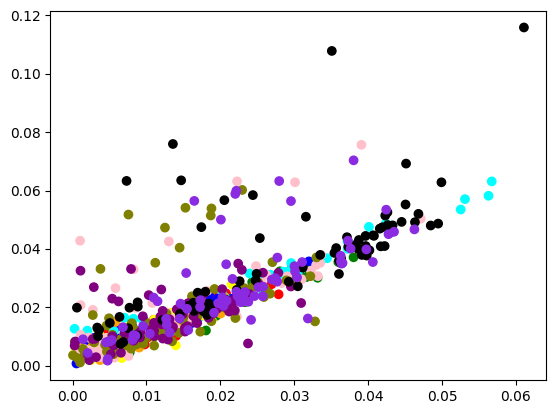

In [47]:
plt.scatter(chunks_np[:, 0], chunks_np[:, 2], color=color_labels)

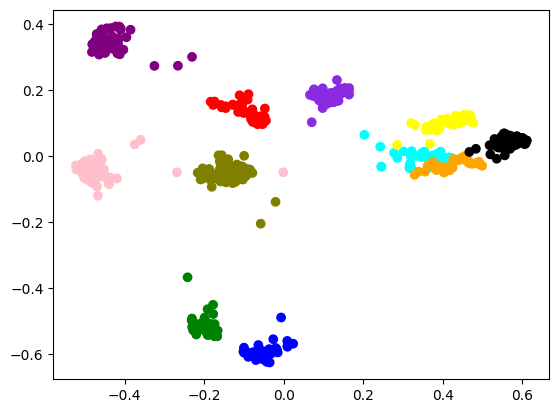

In [48]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 3], color=color_labels)

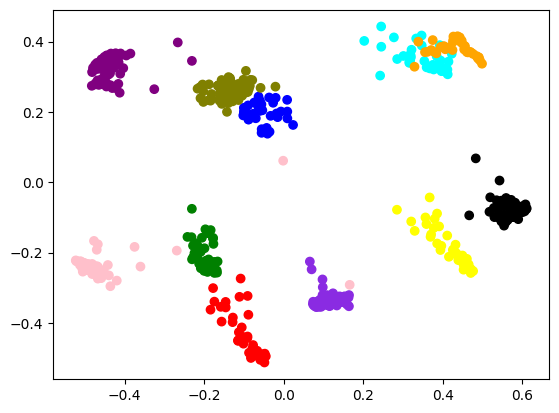

In [49]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 2], color=color_labels)